In [160]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
metrics_path = "metrics/binary_class"
experiment_name = "Binary Classification"

In [175]:
# Load metrics files
training_metrics = [json.load(open(os.path.join(metrics_path, f))) 
                   for f in sorted(os.listdir(metrics_path)) 
                   if f.startswith("train_") and f.endswith(".json")]
validation_metrics = [json.load(open(os.path.join(metrics_path, f))) 
                     for f in sorted(os.listdir(metrics_path))
                     if f.startswith("val_") and f.endswith(".json")]

num_classes = training_metrics[0]['num_classes']

# Process training metrics
training_df = pd.DataFrame([
    {
        'step': m['step'],
        'epoch': m['epoch'],
        'epoch_steps': m['total'],
        'accuracy': m['true_positives'] / m['total'] if m['total'] > 0 else 0,
        'type': 'training',
        **{f'class_{k}_acc': m[str(k)]['true_positives']/m[str(k)]['total'] 
           if m[str(k)]['total'] > 0 else 0 
           for k in range(num_classes)},
        **{f'class_{k}_fp': m[str(k)]['false_positives']/m[str(k)]['total'] 
           if m[str(k)]['total'] > 0 else 0 
           for k in range(num_classes)}  
    }
    for m in training_metrics
])

# Process validation metrics
validation_df = pd.DataFrame([
    {
        'step': m['step'],
        'epoch_steps': m['total'],
        'epoch': m['epoch'],
        'accuracy': m['true_positives'] / m['total'] if m['total'] > 0 else 0,
        'type': 'validation',
        **{f'class_{k}_acc': m[str(k)]['true_positives']/m[str(k)]['total'] 
           if m[str(k)]['total'] > 0 else 0 
           for k in range(num_classes)},
        **{f'class_{k}_fp': m[str(k)]['false_positives']/m[str(k)]['total'] 
           if m[str(k)]['total'] > 0 else 0 
           for k in range(num_classes)}  
    }
    for m in validation_metrics
])

steps_per_epoch = max(training_df['epoch_steps'])
training_df['total_steps'] = (training_df['epoch'] - 1)* steps_per_epoch + training_df['step']
validation_df['total_steps'] = (validation_df['epoch'] - 1) * steps_per_epoch + validation_df['step']


In [176]:
class_cols = [col for col in training_df.columns if col.startswith('class_')]

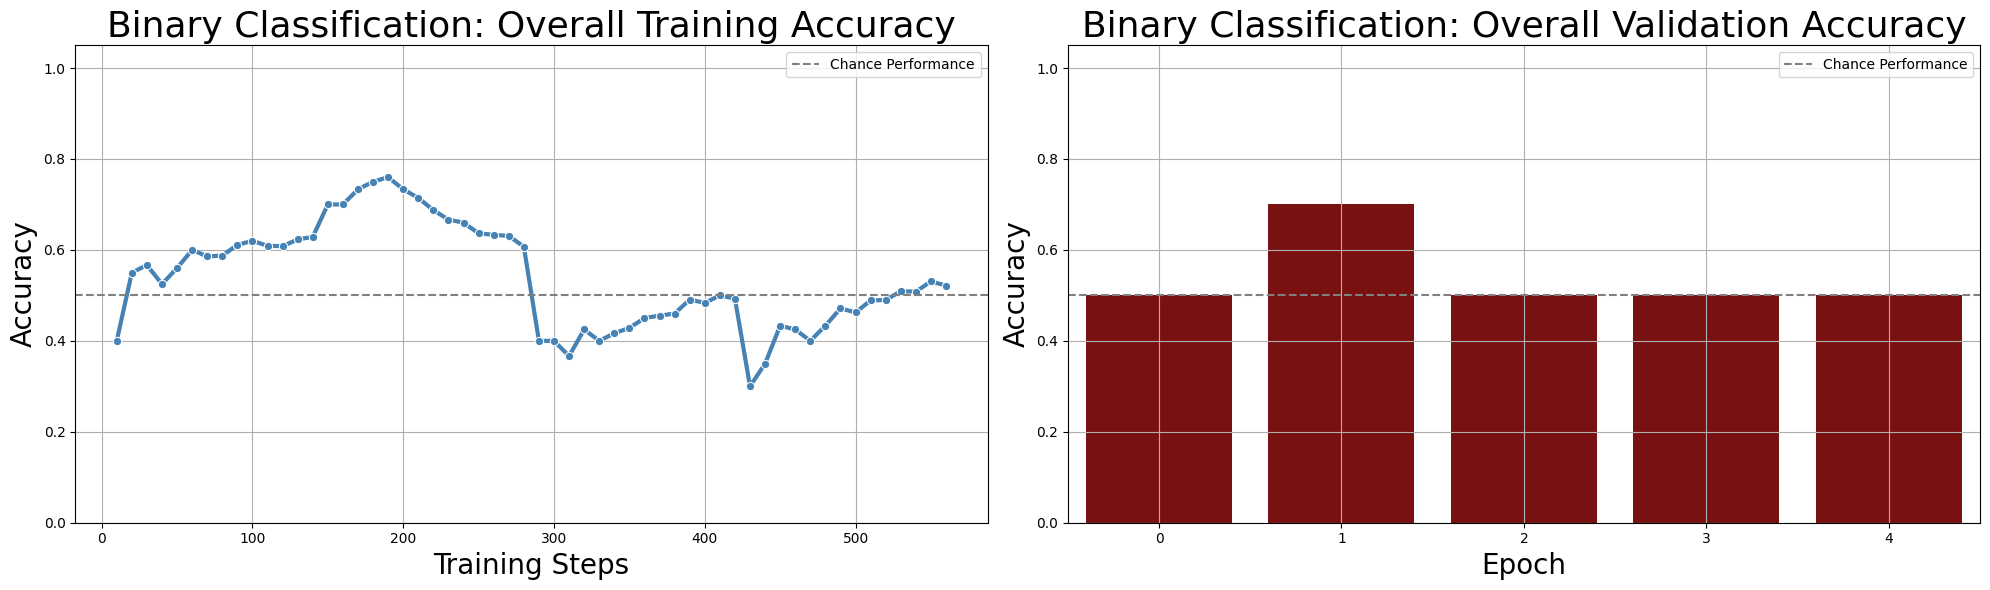

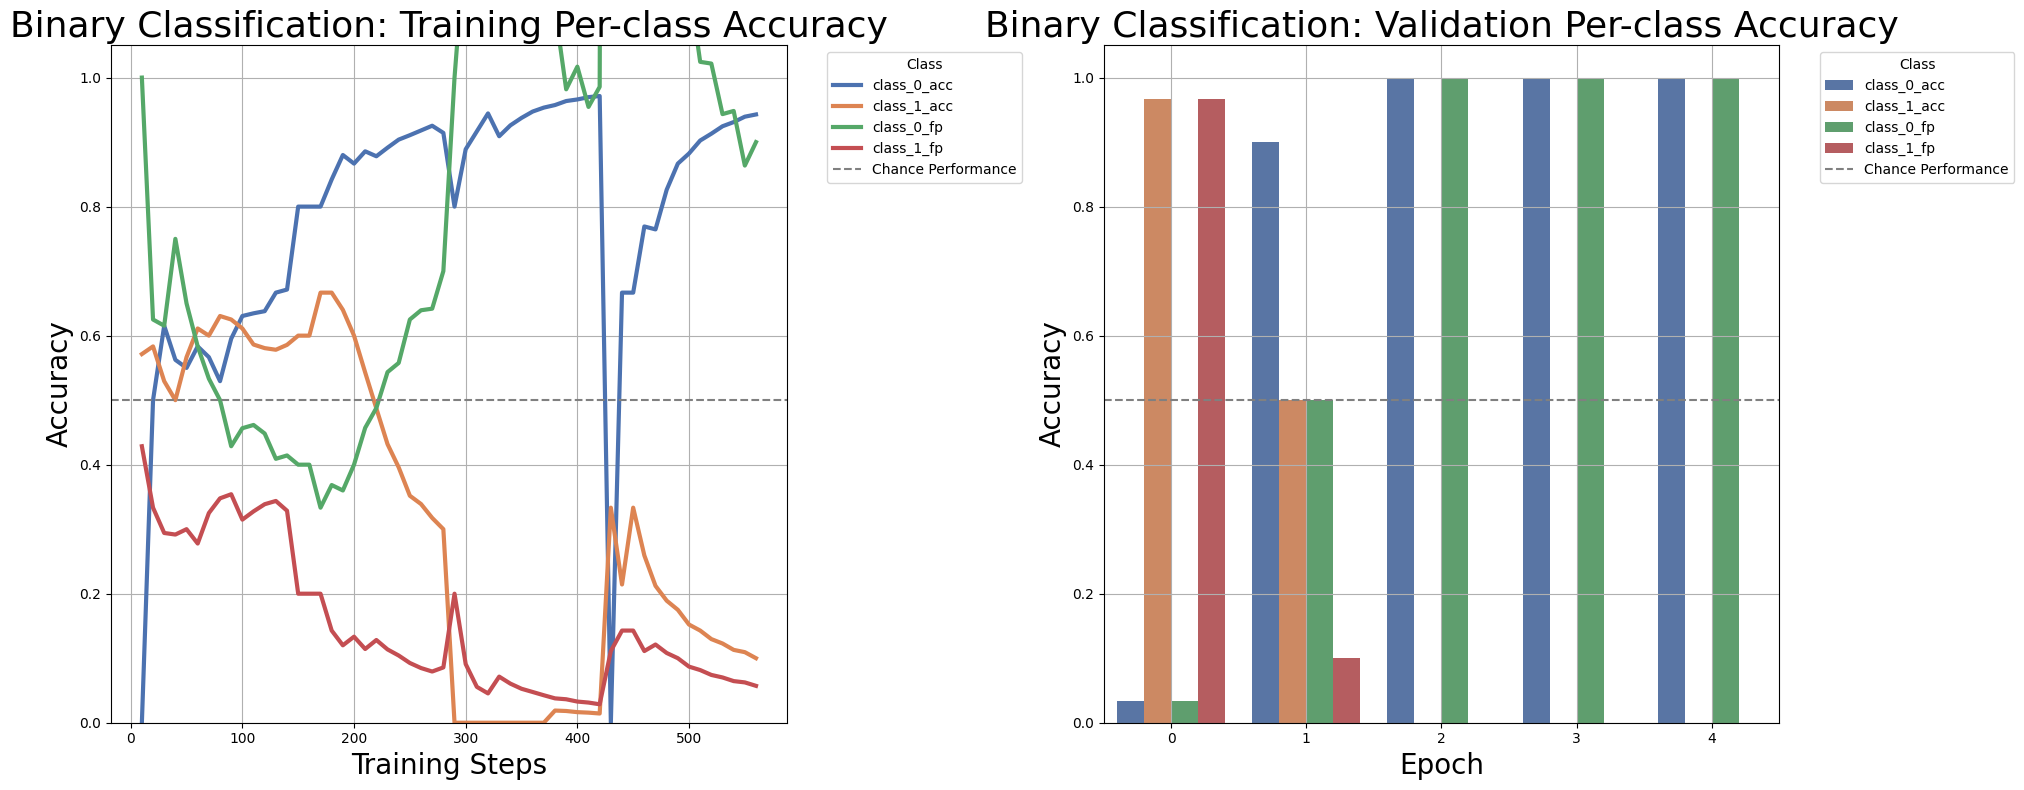

In [201]:
# Plot overall accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

chance_performance = 1/num_classes

# Training accuracy barplot
sns.lineplot(data=training_df, x='total_steps', y='accuracy', ax=ax1, color='steelblue', lw=3, marker='o')
ax1.set_title(f'{experiment_name}: Overall Training Accuracy', fontsize=26)
ax1.set_ylim(0, 1.05)

ax1.axhline(chance_performance, color='gray', linestyle='--', label='Chance Performance')
ax1.legend()
ax1.set_xlabel('Training Steps', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.grid(True)

# Validation accuracy barplot
sns.barplot(data=validation_df, x='epoch', y='accuracy', ax=ax2, color='darkred')
ax2.axhline(chance_performance, color='gray', linestyle='--', label='Chance Performance')
ax2.legend()
ax2.set_title(f'{experiment_name}: Overall Validation Accuracy', fontsize=26)
ax2.set_ylim(0, 1.05)
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_ylabel('Accuracy', fontsize=20)
ax2.grid(True)

plt.tight_layout()
plt.show()

# Plot per-class accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Reshape data for better plotting
train_melted = pd.melt(training_df, 
                      id_vars=['total_steps'], 
                      value_vars=class_cols, 
                      var_name='class',
                      value_name='class_accuracy')

val_melted = pd.melt(validation_df, 
                     id_vars=['epoch'], 
                     value_vars=class_cols, 
                     var_name='class',
                     value_name='class_accuracy')

color_palette = sns.color_palette("deep", len(class_cols))

# Training per-class plot
sns.lineplot(data=train_melted, x='total_steps', y='class_accuracy', 
            hue='class', lw=3,
            markers=True, dashes=False, ax=ax1, palette=color_palette)
ax1.axhline(chance_performance, color='gray', linestyle='--', label='Chance Performance')
ax1.legend()
ax1.set_title(f'{experiment_name}: Training Per-class Accuracy', fontsize=26)
ax1.set_xlabel('Training Steps', fontsize=20)
ax1.set_ylabel('Accuracy', fontsize=20)
ax1.set_ylim(0, 1.05)
ax1.grid(True)
ax1.legend(title='Class', bbox_to_anchor=(1.05, 1))

# Validation per-class plot
sns.barplot(data=val_melted, x='epoch', y='class_accuracy', 
                hue='class', lw=3,
                ax=ax2, palette=color_palette)
ax2.axhline(chance_performance, color='gray', linestyle='--', label='Chance Performance')
ax2.legend()
ax2.set_title(f'{experiment_name}: Validation Per-class Accuracy', fontsize=26)
ax2.set_ylim(0, 1.05)
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_ylabel('Accuracy', fontsize=20)
ax2.grid(True)
ax2.legend(title='Class', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_94271/2881966467.py:107: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  confusion_matrix[i,i] = float(latest_metrics[f'class_{i}_acc'])
/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_94271/2881966467.py:111: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  fp_rate = float(latest_metrics[f'class_{i}_fp'])


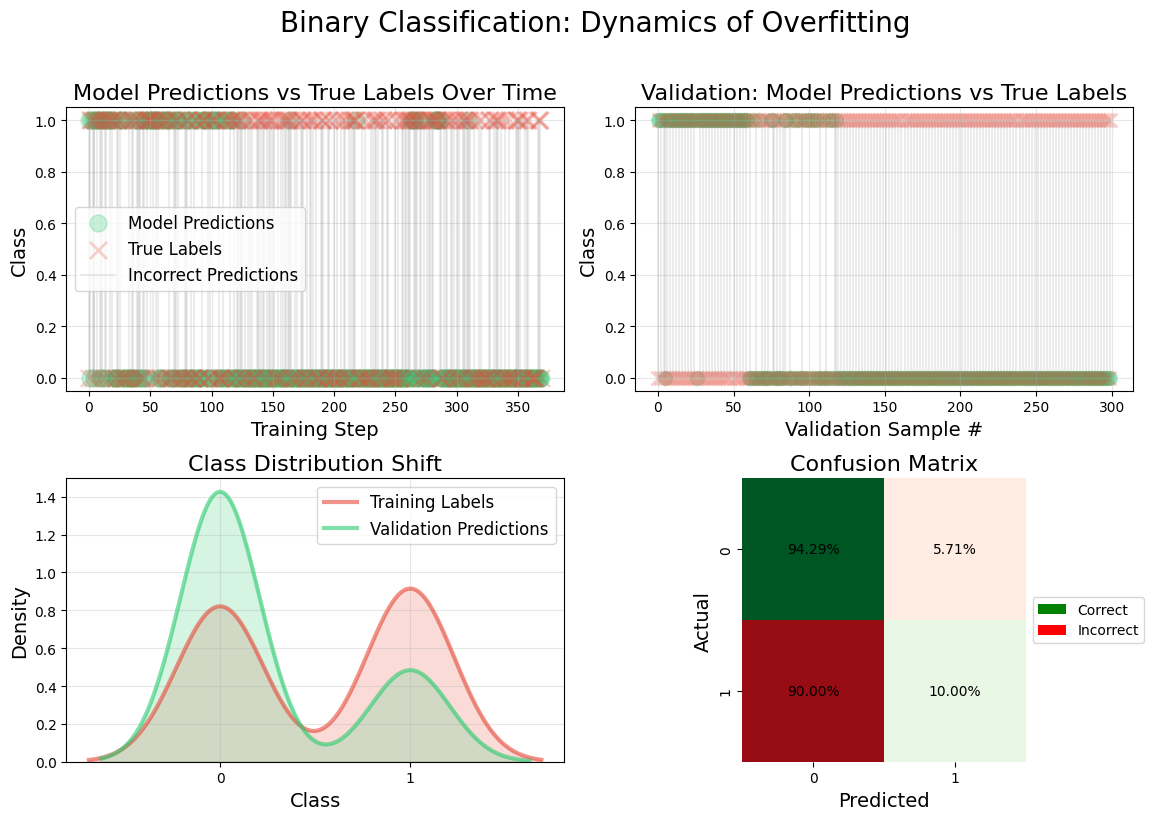

In [208]:
# Plot guesses vs labels over time and distributions
train_index = -1
val_index = -1

train_val_ratio = len(training_metrics) / len(validation_metrics)

train_labels = []
train_predictions = []
val_labels = []
val_predictions = []
for i in range(len(validation_metrics)):
    train_label = training_metrics[int(i * train_val_ratio)]['true_classes']
    train_prediction = training_metrics[int(i * train_val_ratio)]['predicted_classes']
    val_label = validation_metrics[i]['true_classes']
    val_prediction = validation_metrics[i]['predicted_classes']
    train_labels.extend(train_label)
    train_predictions.extend(train_prediction)
    val_labels.extend(val_label)
    val_predictions.extend(val_prediction)

# Create figure with four subplots - two on top, two on bottom
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)

# Training predictions over time
ax1 = fig.add_subplot(gs[0, 0])

# Plot connecting lines between predictions and labels to show discrepancy
plt.plot([i, i], [train_predictions[i], train_labels[i]], 
         color='gray', alpha=0.15, linestyle='-')

plt.scatter(range(len(train_predictions)), train_predictions, 
           alpha=0.25, label='Model Predictions', s=150, color='#2ecc71')
plt.scatter(range(len(train_labels)), train_labels, marker='x', linewidths=2,
           alpha=0.25, label='True Labels', s=150, color='#e74c3c')
# Plot connecting lines between predictions and labels for training set
for i in range(len(train_predictions)):
    plt.plot([i, i], [train_predictions[i], train_labels[i]], 
             color='gray', alpha=0.15, linestyle='-', label="Incorrect Predictions")

plt.title('Model Predictions vs True Labels Over Time', fontsize=16)
plt.xlabel('Training Step', fontsize=14)
plt.ylabel('Class', fontsize=14)

# Remove duplicates in legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.legend(*zip(*unique), fontsize=12, loc='best')
plt.grid(True, alpha=0.3)

# Validation predictions at each epoch
ax2 = fig.add_subplot(gs[0, 1])

# Plot connecting lines between predictions and labels for validation set
for i in range(len(val_predictions)):
    plt.plot([i, i], [val_predictions[i], val_labels[i]], 
             color='gray', alpha=0.15, linestyle='-')

plt.scatter(range(len(val_predictions)), val_predictions,
           alpha=0.25, label='Model Predictions', s=100, color='#2ecc71')
plt.scatter(range(len(val_labels)), val_labels, marker='x', linewidths=2,
           alpha=0.25, label='True Labels', s=100, color='#e74c3c')

plt.title('Validation: Model Predictions vs True Labels', fontsize=16)
plt.xlabel('Validation Sample #', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.grid(True, alpha=0.3)

# Distribution plot on bottom left
ax3 = fig.add_subplot(gs[1, 0])

# Plot KDE for training labels with higher bandwidth for smoother curve
sns.kdeplot(data=train_labels, label='Training Labels', bw_adjust=1.5,
            color='#e74c3c', alpha=0.6, linewidth=3)

# Plot KDE for validation predictions
sns.kdeplot(data=val_predictions, label='Validation Predictions', bw_adjust=1.5,
            color='#2ecc71', alpha=0.6, linewidth=3)

plt.title('Class Distribution Shift', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12, loc="best")
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show class numbers
plt.xticks(range(10))

# Add a subtle fill under the KDE curves
plt.fill_between(plt.gca().lines[0].get_xdata(), plt.gca().lines[0].get_ydata(), 
                alpha=0.2, color='#e74c3c')
plt.fill_between(plt.gca().lines[1].get_xdata(), plt.gca().lines[1].get_ydata(),
                alpha=0.2, color='#2ecc71')

# Create confusion matrix from accuracy and false positive columns
ax4 = fig.add_subplot(gs[1, 1])

# Get the latest row from training_df
latest_metrics = training_df[training_df['total_steps'] == int(training_df['total_steps'].max())]

# Extract class accuracies and false positives
num_classes = len([col for col in training_df.columns if col.startswith('class_') and col.endswith('_acc')])
confusion_matrix = np.zeros((num_classes, num_classes))

# Fill in true positives (diagonal)
for i in range(num_classes):
    confusion_matrix[i,i] = float(latest_metrics[f'class_{i}_acc'])
    
# Fill in false positives (columns)
for i in range(num_classes):
    fp_rate = float(latest_metrics[f'class_{i}_fp'])
    # Distribute false positives evenly among other classes
    for j in range(num_classes):
        if i != j:
            confusion_matrix[j,i] = float(fp_rate / (num_classes-1))

# Create a mask for diagonal elements
diagonal_mask = np.eye(num_classes, dtype=bool)

# Plot off-diagonal elements (incorrect predictions) in red
sns.heatmap(
    confusion_matrix,
    mask=diagonal_mask,  # Mask the diagonal
    cmap='Reds',
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
    vmin=0,
    vmax=1,
    square=True,
    cbar=False,
    ax=ax4
)

# Plot diagonal elements (correct predictions) in green
sns.heatmap(
    confusion_matrix,
    mask=~diagonal_mask,  # Mask everything except diagonal
    cmap='Greens',
    xticklabels=range(num_classes),
    yticklabels=range(num_classes),
    vmin=0,
    vmax=1,
    square=True,
    cbar=False,
    ax=ax4
)

# Add annotations
for i in range(num_classes):
    for j in range(num_classes):
        text = f'{confusion_matrix[i, j]:.2%}'
        ax4.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='black')

ax4.set_title('Confusion Matrix', fontsize=16)
ax4.set_xlabel('Predicted', fontsize=14)
ax4.set_ylabel('Actual', fontsize=14)

# Add a legend for confusion matrix interpretation
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Correct'),
    Patch(facecolor='red', label='Incorrect')
]
ax4.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.suptitle(f'{experiment_name}: Dynamics of Overfitting', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()
